# Predicting severity of crashes -- Modeling


## Capstone Project Two : Springboard Data Science career track

## Notebook by Tzega Abera

credit: 
https://github.com/debisree/

## 1. Introduction

The City of Chicago is the largest city in the state of Illinois and the third-largest city in the United States. It is a major center for commerce, industry, transportation, and culture. The city has over 2.7 million residents and every year, countless individuals are affected by devastating traffic accidents. Today, Chicago is focusing on improving the quality of life for the residents by implementing the initiatives called Vision Zero aiming to prevent these tragedies. One of the city's main targets is to keep its roads safe by reducing speed-related fatal and serious injury crashes by 25%.

### 1.1 The Problem

The purpose of this data science project is to conduct a crash severity analysis for the city of Chicago and build a predictive model for fatal and serious injury crushes based on a number of crash- types (determine which ones resulted in fatal or serious injuries) boasted by neighborhoods within the city.

This model will be used to provide guidance for the City of Chicago to predict if a traffic crash will be severe/fatal helping the city to optimize allocation of it's emergency resources.


### 1.2 The Data

The city of chicago hosts the original dataset in their website. 
https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if

The data is updated very frequently and the original dataset contains over 700,000 rows. For the purpose of this project, we will use only 200,000 rows.

### 1.3 Imports

In [98]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import scipy.stats as stats
import folium

from library.sb_utils import save_file

In [2]:
df = pd.read_csv('../data/traffic_data_step3_features.csv')


In [3]:
df.shape

(199999, 38)

# 2. Feature engineering

The goal of this project is to be able to predict if a crash will result in a serious/fata injuries. Thus we will focus on 
the column MOST_SEVERE_INJURY which contain the information if each crash resulted in injuries.

In [4]:
#look into the column MOST_SEVERE_INJURY
df["MOST_SEVERE_INJURY"].unique()

array(['REPORTED, NOT EVIDENT', 'NO INDICATION OF INJURY',
       'NONINCAPACITATING INJURY', 'INCAPACITATING INJURY', nan, 'FATAL'],
      dtype=object)

In [5]:
class_counts = df['MOST_SEVERE_INJURY'].value_counts()
class_counts

NO INDICATION OF INJURY     172300
NONINCAPACITATING INJURY     15367
REPORTED, NOT EVIDENT         8246
INCAPACITATING INJURY         3415
FATAL                          226
Name: MOST_SEVERE_INJURY, dtype: int64

We have a large number of crashes that resulted in no injuries while about 15% of the crashes resulted in injures or were fatal.
Next, we will create a new column called SEVERE_INJURY. The column takes a value of 1 if the value 
in the MOST_SEVERE_INJURY column is one of the specified injury categories: "NONINCAPACITATING INJURY", "REPORTED, 
"NOT EVIDENT", "REPORTED", "INCAPACITATING INJURY", or "FATAL". Otherwise, the value of SEVERE_INJURY is 0.

This binary classification column will be our target colum. 

In [6]:
# create a new column SEVERE_INJURY with 1 for specified categories, 0 otherwise
df['SEVERE_INJURY'] = df['MOST_SEVERE_INJURY'].apply(lambda x:
    1 if x in ['NONINCAPACITATING INJURY', 'REPORTED, NOT EVIDENT', 'REPORTED', 'INCAPACITATING INJURY', 'FATAL'] else 0)

# print the updated DataFrame
df.head()

,CRASH_RECORD_ID,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,ALIGNMENT,...,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION,CRASH_YEAR,SEVERE_INJURY
0,79c7a2ce89f446262efd86df3d72d18b04ba487024b7c4...,3/25/2019 14:43,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,TURNING,ONE-WAY,STRAIGHT AND LEVEL,...,2.0,0.0,14,2,3,41.884547,-87.641201,POINT (-87.64120093714 41.884547224337),2019,1
1,792b539deaaad65ee5b4a9691d927a34d298eb33d42af0...,9/5/2018 8:40,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,ANGLE,NOT DIVIDED,STRAIGHT AND LEVEL,...,2.0,0.0,8,4,9,41.968562,-87.740659,POINT (-87.740659314632 41.968562453871),2018,0
2,0115ade9a755e835255508463f7e9c4a9a0b47e9304238...,7/15/2022 0:45,30,UNKNOWN,UNKNOWN,CLEAR,POORLY LIT,ANGLE,NOT DIVIDED,STRAIGHT AND LEVEL,...,2.0,0.0,0,6,7,41.886336,-87.716203,POINT (-87.716203130599 41.886336409761),2022,0
3,05b1982cdba5d8a00e7e76ad1ecdab0e598429f78481d2...,8/29/2022 11:30,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,FOUR WAY,STRAIGHT AND LEVEL,...,3.0,0.0,11,2,8,41.749348,-87.721097,POINT (-87.721096727406 41.749348170421),2022,0
4,017040c61958d2fa977c956b2bd2d6759ef7754496dc96...,7/15/2022 18:50,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,NOT DIVIDED,STRAIGHT AND LEVEL,...,2.0,0.0,18,6,7,41.925111,-87.667997,POINT (-87.667997321599 41.925110815832),2022,0


In [7]:
#check the size of the newly created dataframe to verify the number of columns
df.shape

(199999, 39)

To check if we have a class imbalance in out dataset, we need to examine the distribution of the target variable. 
A class imbalance occurs when the distribution of one or more classes is significantly different from the others.

In [8]:
#checking if we have a class imbalance

class_counts = df['SEVERE_INJURY'].value_counts()
class_counts

0    172745
1     27254
Name: SEVERE_INJURY, dtype: int64

In [9]:
#calclulating the percentage of each value

class_percentages = pd.Series([(x / df.shape[0]) * 100.00 for x in class_counts])
class_percentages

0    86.372932
1    13.627068
dtype: float64

We have over 80% of data showing the value "0". THis indicates a class imbalance

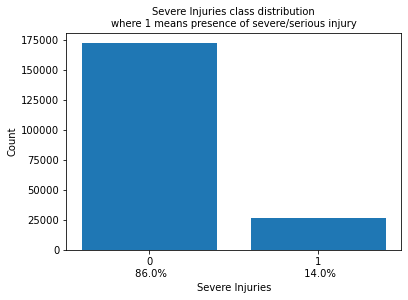

In [10]:
#To visually inspect class imbalance in a our dataset, we create a bar chart showing 
#the distribution of the target variable

fig, ax = plt.subplots()
ax.bar(class_counts.index, class_counts)
ax.set_xticks([0, 1])
ax.set_xticklabels(class_percentages.index.astype(str) + '\n' + ' ' +
                   class_percentages.round(0).astype(str) + '%')
ax.set_ylabel('Count')
ax.set_xlabel('Severe Injuries')
ax.set_title('Severe Injuries class distribution\nwhere 1 means presence of severe/serious injury',
              fontsize = 10)
plt.show()

Balanced and Imbalanced Classes

For a binary classification problem (two classes), the problem is called balanced if the number of elements of each class is about the same--in other words, each class would have a size that is about 50% of the total number of elements in the dataset. In this particular case study, we can say that this problem is imbalanced, since the difference in the percentages is about close to 80%. When there is a imbalance among the classes in a binary classification problem, one usually refers to them as the minority class, and the majority class.

There are two important challenges posed by ICPs:

    The difference in the size of the classes is inherent to the problem under study. This means that one cannot pave this difference by adding more elements to the minority class.

    Classification algorithms are usually negatively affected by the lack of sufficient samples of the minority class, in that the models built with them are practically unable to differentiate the minority class from the majority class, where the former is the one of interest. 

Since this particular case study deals with an imbalance among the classes, we will not be able to build useful models with the given dataset--without introducing additional interventions. One  approach to deal with ICP is by either generating sythetic data (oversampling), or by generating a set of smaller "majority classes" by taking chunks from the original majority class (undersampling). In general, these approaches are collectively referred to as resampling.

For this case study, we will use the undersampling technique to balance the classes in our dataset. This will be achieved by removing some of the instances from the over-represented class (0, the absence of severe injuries) to match the number of instances in the under-represented class (1, the presence of severe injuries)


Now, our dataset is balanced.
Next, we will check for null value

In [13]:
print(df.isna().sum())

CRASH_RECORD_ID                     0
CRASH_DATE                          0
POSTED_SPEED_LIMIT                  0
TRAFFIC_CONTROL_DEVICE              0
DEVICE_CONDITION                    0
WEATHER_CONDITION                   0
LIGHTING_CONDITION                  0
FIRST_CRASH_TYPE                    0
TRAFFICWAY_TYPE                     0
ALIGNMENT                           0
ROADWAY_SURFACE_COND                0
ROAD_DEFECT                         0
REPORT_TYPE                      5244
CRASH_TYPE                          0
DAMAGE                              0
DATE_POLICE_NOTIFIED                0
PRIM_CONTRIBUTORY_CAUSE             0
SEC_CONTRIBUTORY_CAUSE              0
STREET_NO                           0
STREET_DIRECTION                    1
STREET_NAME                         0
BEAT_OF_OCCURRENCE                  3
NUM_UNITS                           0
MOST_SEVERE_INJURY                445
INJURIES_TOTAL                    441
INJURIES_FATAL                      0
INJURIES_INC

In [43]:
#Fill with the most frequent category: her we will replace the missing values with the mode, 
#i.e., the most frequent category in the column. This is a good option because the missing values are few and do not 
#significantly affect the distribution of our data.    

df['REPORT_TYPE'].fillna(df['REPORT_TYPE'].mode()[0], inplace=True)
df['MOST_SEVERE_INJURY'].fillna(df['MOST_SEVERE_INJURY'].mode()[0], inplace=True)
df['INJURIES_TOTAL'].fillna(df['INJURIES_TOTAL'].mode()[0], inplace=True)
df['INJURIES_INCAPACITATING'].fillna(df['INJURIES_INCAPACITATING'].mode()[0], inplace=True)
df['INJURIES_REPORTED_NOT_EVIDENT'].fillna(df['INJURIES_REPORTED_NOT_EVIDENT'].mode()[0], inplace=True)
df['INJURIES_NO_INDICATION'].fillna(df['INJURIES_NO_INDICATION'].mode()[0], inplace=True)
df['INJURIES_UNKNOWN'].fillna(df['INJURIES_UNKNOWN'].mode()[0], inplace=True)
df['LATITUDE'].fillna(df['LATITUDE'].mode()[0], inplace=True)
df['LONGITUDE'].fillna(df['LONGITUDE'].mode()[0], inplace=True)
df['LOCATION'].fillna(df['LOCATION'].mode()[0], inplace=True)
df['INJURIES_NON_INCAPACITATING'].fillna(df['INJURIES_NON_INCAPACITATING'].mode()[0], inplace=True)
df['BEAT_OF_OCCURRENCE'].fillna(df['BEAT_OF_OCCURRENCE'].mode()[0], inplace=True)
df['STREET_DIRECTION'].fillna(df['STREET_DIRECTION'].mode()[0], inplace=True)


 

In [44]:
print(df.isna().sum())

CRASH_RECORD_ID                  0
CRASH_DATE                       0
POSTED_SPEED_LIMIT               0
TRAFFIC_CONTROL_DEVICE           0
DEVICE_CONDITION                 0
WEATHER_CONDITION                0
LIGHTING_CONDITION               0
FIRST_CRASH_TYPE                 0
TRAFFICWAY_TYPE                  0
ALIGNMENT                        0
ROADWAY_SURFACE_COND             0
ROAD_DEFECT                      0
REPORT_TYPE                      0
CRASH_TYPE                       0
DAMAGE                           0
DATE_POLICE_NOTIFIED             0
PRIM_CONTRIBUTORY_CAUSE          0
SEC_CONTRIBUTORY_CAUSE           0
STREET_NO                        0
STREET_DIRECTION                 0
STREET_NAME                      0
BEAT_OF_OCCURRENCE               0
NUM_UNITS                        0
MOST_SEVERE_INJURY               0
INJURIES_TOTAL                   0
INJURIES_FATAL                   0
INJURIES_INCAPACITATING          0
INJURIES_NON_INCAPACITATING      0
INJURIES_REPORTED_NO

In [45]:
df.shape

(199999, 39)

# 3. Creating dummy features

In [46]:
#categorical = balanced_data.select_dtypes(include=['object']).columns.tolist()
categorical =df.select_dtypes(include=['object']).columns.tolist()
# Print the list of categorical columns
print("The categorical Columns are: ", categorical)


The categorical Columns are:  []


In [47]:
from sklearn.preprocessing import LabelEncoder
# Create a LabelEncoder object
le = LabelEncoder()

# Loop over each categorical variable and encode its values
#for col in categorical :
    #balanced_data[col] = le.fit_transform(balanced_data[col].astype(str))
for col in categorical :
    df[col] = le.fit_transform(df[col].astype(str))

In [48]:
df.head()

,CRASH_RECORD_ID,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,ALIGNMENT,...,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION,CRASH_YEAR,SEVERE_INJURY
0,129328,72683,30,16,1,2,2,17,10,3,...,2.0,0.0,14,2,3,41.884547,-87.641201,29035,2019,1
1,127783,164940,30,4,3,2,2,0,8,3,...,2.0,0.0,8,4,9,41.968562,-87.740659,93839,2018,0
2,2664,121108,30,17,6,2,4,0,8,3,...,2.0,0.0,0,6,7,41.886336,-87.716203,80760,2022,0
3,14495,147605,30,16,1,2,2,10,6,3,...,3.0,0.0,11,2,8,41.749348,-87.721097,83491,2022,0
4,3569,121243,30,16,1,2,2,10,8,3,...,2.0,0.0,18,6,7,41.925111,-87.667997,48820,2022,0


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199999 entries, 0 to 199998
Data columns (total 39 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH_RECORD_ID                199999 non-null  int32  
 1   CRASH_DATE                     199999 non-null  int32  
 2   POSTED_SPEED_LIMIT             199999 non-null  int64  
 3   TRAFFIC_CONTROL_DEVICE         199999 non-null  int32  
 4   DEVICE_CONDITION               199999 non-null  int32  
 5   WEATHER_CONDITION              199999 non-null  int32  
 6   LIGHTING_CONDITION             199999 non-null  int32  
 7   FIRST_CRASH_TYPE               199999 non-null  int32  
 8   TRAFFICWAY_TYPE                199999 non-null  int32  
 9   ALIGNMENT                      199999 non-null  int32  
 10  ROADWAY_SURFACE_COND           199999 non-null  int32  
 11  ROAD_DEFECT                    199999 non-null  int32  
 12  REPORT_TYPE                   

# 4. Split data into training and testing subsets

In [50]:
from sklearn.model_selection import train_test_split

# Define the features and target variable
columns=['SEVERE_INJURY','CRASH_RECORD_ID',"CRASH_DATE","INJURIES_TOTAL","INJURIES_FATAL","INJURIES_INCAPACITATING","INJURIES_NON_INCAPACITATING", "LOCATION"]
#X = balanced_data.drop(columns, axis=1) # except the target

X = df.drop(columns, axis=1) # except the target

#y = balanced_data['SEVERE_INJURY'] # target variable
y = df['SEVERE_INJURY'] # target variable




In [51]:
# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
from collections import Counter

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({0: 120882, 1: 19117})
Testing target statistics: Counter({0: 51863, 1: 8137})


In [52]:
from imblearn.under_sampling import RandomUnderSampler

under_sampler = RandomUnderSampler(random_state=42)
X_res_train, y_res_train = under_sampler.fit_resample(X_train, y_train)
print(f"Training target statistics: {Counter(y_res)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({0: 19117, 1: 19117})
Testing target statistics: Counter({0: 51863, 1: 8137})


In [53]:
from sklearn.preprocessing import StandardScaler

#feature scaling
scaler = StandardScaler()
X_res_train=scaler.fit_transform(X_res_train)
#X_Test just gets transformed
X_test=scaler.transform(X_test)

# 5. Modeling

## 5.1 KNN Classifier

The KNN Classifier is a simple algorithm that we can use to classify our data points based on the classes of their k nearest neighbors in the feature space. The value of k is a hyperparameter that needs to be specified before training the model. The KNN algorithm assumes that similar data points belong to the same class. To classify a new data point, the algorithm looks for the k nearest data points in the feature space and assigns the class that appears most frequently among those k neighbors. 
Even though the KNN algorithm is easy to implement, it can be slow and memory-intensive when dealing with large datasets.

Next, we will explor the performance of the KNN algorithm with different values of k (1-10) and determine the optimal value for a our dataset. 

In [62]:
from sklearn.neighbors import KNeighborsClassifier


test_scores = []
train_scores = []
    
#The for loop is used to iterate through different values of k 
#(the number of nearest neighbors to consider) and to fit the KNN model to the training data for each value of k
for i in range(1,10):

    knn = KNeighborsClassifier(i)
    knn.fit(X_res_train,y_res_train)
    
#For each value of k, the accuracy of the model is evaluated using the score method, which calculates the mean 
#accuracy on the given test data and labels (represented by X_test and y_test). 
#The resulting train_scores and test_scores lists store the accuracy scores for each value of k.
    
    train_scores.append(knn.score(X_res_train,y_res_train))
    test_scores.append(knn.score(X_test,y_test))

In [63]:
print(test_scores)

[0.9176333333333333, 0.9427666666666666, 0.9251, 0.9417333333333333, 0.9255, 0.9396, 0.92435, 0.9355166666666667, 0.9235666666666666]


In [64]:
print(train_scores)


[1.0, 0.9541507558717371, 0.9681696918972642, 0.9565046816969189, 0.9592770832243552, 0.9548830883506826, 0.9551446356645917, 0.9533661139300099, 0.9522414604802009]


In [65]:
best_k = np.argmax(train_scores) + 1 
best_k

1

The best_k value is 1, meaning that the KNN algorithm achieved the highest training accuracy with only one nearest neighbor.

The value of k determines the number of nearest neighbors to consider when making a prediction for a new data point. When k is set to 1, the algorithm only considers the closest data point to the new point and uses its label to make the prediction.

Having a value of 1 for the best_k possibly indicates that the dataset is relatively simple, where each data point has a clear and distinct class that is well-separated from other classes. In this case, using a single nearest neighbor could result in high accuracy, since the closest data point is likely to have the same class label as the new data point.

However, it is important to keep in mind that using only one nearest neighbor can also lead to overfitting on the training data and poor generalization on new, unseen data. Therefore, it is usually recommended to consider a range of values for k and select the one that results in the best performance on the testing data.

C:\Users\Sebuh\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Sebuh\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


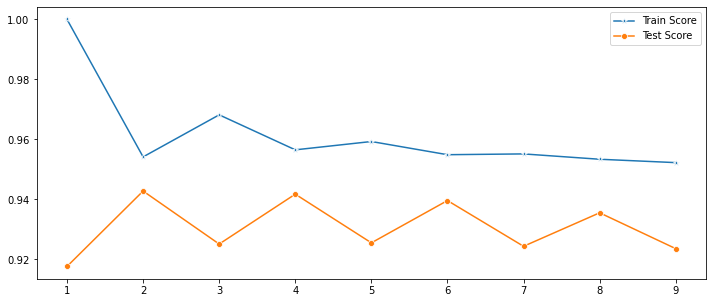

In [66]:
plt.figure(figsize=(12,5))
p = sns.lineplot(range(1,10),train_scores,marker='*',label='Train Score')
p = sns.lineplot(range(1,10),test_scores,marker='o',label='Test Score')


Based on the plot above, after considering a  range of values for k (1-9), k=2 results in the best performance on the testing data.

Thus, next we will build a model with k=2, which means that the model will consider the two nearest neighbors of each point to make its predictions.

In [153]:
knn = KNeighborsClassifier(2)
knn.fit(X_res_train, y_res_train)
train_score_optimal = knn.score(X_res_train, y_res_train)
test_score_optimal = knn.score(X_test, y_test)
print("Accuracy of the model on the training dataset is:", train_score_optimal)
print("Accuracy of the model on the test dataset is:" , test_score_optimal)

Accuracy of the model on the training dataset is: 0.9541507558717371
Accuracy of the model on the test dataset is: 0.9427666666666666


The confusion matrix below can be used to evaluate the performance of the classifier in terms of its ability to correctly predict the class labels of the testing data. Specifically, it can be used to compute various performance metrics such as accuracy, precision, recall, and F1-score.

In [154]:
from sklearn.metrics import confusion_matrix

y_pred = knn.predict(X_test)
pl = confusion_matrix(y_test,y_pred)

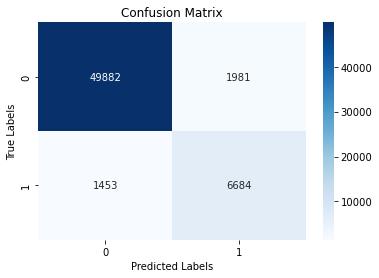

In [155]:
plt.figure(figsize=(6, 4))
sns.heatmap(pl, annot=True, fmt='', cmap='Blues')    
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

True Positives (TP): The classifier correctly predicted that 6684 samples were positive.

True Negatives (TN): The classifier correctly predicted that 49882 samples were negative.

False Positives (FP): The classifier incorrectly predicted that 1981 samples were positive when they were actually negative.

False Negatives (FN): The classifier incorrectly predicted that 1453 samples were negative when they were actually positive.

In [165]:
Accuracy_knn=knn.score(X_test,y_test)
print("Accuracy of the model on the test dataset is:", Accuracy_knn)

Accuracy of the model on the test dataset is: 0.9427666666666666


### Print the classification report

Next, we will print he classification report which provides a summary of the performance of  model on a set of test data, including precision, recall, and F1-score for each class, as well as the overall accuracy.

In [71]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print("The classification report for the KNN Classifier is: \n" , report)

The classification report for the KNN Classifier is: 
               precision    recall  f1-score   support

           0       0.97      0.96      0.97     51863
           1       0.77      0.82      0.80      8137

    accuracy                           0.94     60000
   macro avg       0.87      0.89      0.88     60000
weighted avg       0.94      0.94      0.94     60000



Overall, these results suggest that the classifier has a high accuracy and performs reasonably well in terms of precision, recall, and F1-score. However, the relatively high number of false positives and false negatives indicates that there is still room for improvement.

In [141]:
#Cross Validation

cv_scores_test= cross_val_score(knn,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(knn,X_res_train,y_res_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_knn_test= cv_scores_test.mean()
cv_scores_knn_train= cv_scores_train.mean()
cv_scores_std_knn= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_knn_test))
print ('Mean cross validation train score: ' +str(cv_scores_knn_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_knn))

[0.9517636  0.94618155 0.95197783 0.94898184 0.94673428]
Mean cross validation test score: 0.9491278207021114
Mean cross validation train score: 0.9793528819880521
Standard deviation in cv scores: 0.0024290212351469657


### 5.1.1 KNN Hyperparameter tuning: Grid Search 

The K parameter holds significant importance in determining the performance of the K nearest neighbors algorithm. While the model's performance may not be unsatisfactory, it is possible that a broader range of neighbor values for K could yield better results. To avoid fitting multiple models iteratively, a grid search technique can be employed to determine the optimal value. It is customary to apply a grid search approach for fine-tuning all adjustable parameters. The process involves defining a range of values for the parameter under consideration, comparing the model outcomes for each value in the grid, and selecting the best performing one.

In [73]:
from sklearn.model_selection import GridSearchCV
param_grid = {'n_neighbors':np.arange(1,50)}
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(X_res_train,y_res_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

In [74]:
print("Best Score:" + str(knn_cv.best_score_))
print("Best Parameters: " + str(knn_cv.best_params_))

Best Score:0.9343778122826946
Best Parameters: {'n_neighbors': 9}


Based on the output Best Score is 0.9343, meaning the K-Nearest Neighbors classifier achieved a mean cross-validated score of approximately 0.93 during the grid search over the hyperparameters.

This means that, on average, the KNN classifier achieved an accuracy of around 93% across the different folds of the cross-validation procedure. However, this score was obtained using cross-validation on the training data, and may not necessarily generalize well to new, unseen data.

To obtain a more reliable estimate of the model's performance, we will now evaluate it on a separate test set that was not used during the hyperparameter tuning process.

In [75]:
# Create a new KNN classifier with the best hyperparameters found during grid-search cross-validation
best_knn = KNeighborsClassifier(n_neighbors=knn_cv.best_params_['n_neighbors'])

# Fit the model to the training data
best_knn.fit(X_res_train, y_res_train)

# Evaluate the model on the test data
y_pred = best_knn.predict(X_test)
test_score = accuracy_score(y_test, y_pred)

# Print the test score
print("Test score:", test_score)


Test score: 0.9235666666666666


The resulting test score of 0.923566 indicates that the classifier correctly classified approximately 92.35% of the samples in the test set. This is a decent performance and suggests that the classifier may be useful for making predictions on new, unseen data.

## 5.2. Fit Random Forest Classifier

In [96]:
from sklearn.ensemble import RandomForestClassifier
# Create an instance of the Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100, max_depth=5)

# Fit the classifier to the training data
rfc.fit(X_res_train, y_res_train)

#Predict using the model:

y_predict_rfc = rfc.predict(X_test)

#Confusion matrix:

cnf_matrix = confusion_matrix(y_test, y_predict_rfc)
print(cnf_matrix)
Accuracy_rfc=rfc.score(X_test,y_test)
print(Accuracy_rfc)

[[51800    63]
 [   44  8093]]
0.9982166666666666


In [106]:
from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import train_test_split

cv_scores_test= cross_val_score(rfc,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(rfc,X_res_train,y_res_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_rfc_test= cv_scores_test.mean()
cv_scores_rfc_train= cv_scores_train.mean()
cv_scores_std_rfc= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_rfc_test))
print ('Mean cross validation train score: ' +str(cv_scores_rfc_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_rfc))

[0.99999959 0.99999496 0.99999976 0.99999751 0.99998839]
Mean cross validation test score: 0.9999960433810194
Mean cross validation train score: 0.9999894520637491
Standard deviation in cv scores: 4.200982856380707e-06


Overall, the result above suggest that the model is performing very well, with high accuracy and consistent performance across different folds. 
Note: These results are based on the specific data and cross-validation procedure used, and may not necessarily generalize to new data.

## 5.3 LogisticRegression

In [115]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver = 'liblinear', max_iter = 500, C = 1000)

#create an actual model using the "fit" method for the class applied to the training set
classifier.fit(X_res_train, y_res_train)


LogisticRegression(C=1000, max_iter=500, solver='liblinear')

In [116]:
y_predict_test = clf.predict(X_test)
y_predict_training = clf.predict(X_res_train)

In [122]:
#compute performance metrics (in this case, accuracy) for the training and test predictions
accuracy_test_log = accuracy_score(y_test, y_predict_test)
print("Accuracy on test set:", accuracy_test)
accuracy_training_log = accuracy_score(y_res_train, y_predict_training)
print("Accuracy on training set:", accuracy_training)

Accuracy on test set: 0.9999833333333333
Accuracy on training set: 1.0


In [118]:
print("Classification Report for Training Data")
print(classification_report(y_res_train, classifier.predict(X_res_train)))

Classification Report for Training Data
              precision    recall  f1-score   support

           0       0.96      0.88      0.92     19117
           1       0.89      0.96      0.92     19117

    accuracy                           0.92     38234
   macro avg       0.92      0.92      0.92     38234
weighted avg       0.92      0.92      0.92     38234



In [119]:
print("Classification Report for Test Data")
print(classification_report(y_test, classifier.predict(X_test)))

Classification Report for Test Data
              precision    recall  f1-score   support

           0       0.99      0.87      0.93     51863
           1       0.55      0.96      0.70      8137

    accuracy                           0.89     60000
   macro avg       0.77      0.92      0.81     60000
weighted avg       0.93      0.89      0.90     60000



The model's training accuracy (0.92) is very good (i.e, it is close to 1--or 100%). This leads to the conclusion that there is only a small "bias" in the model.

The model's test accuracy (0.89) is less than the accuracy of the training data, i.e.,there is a a slight "variance" between the training accuracy and the test accuracy. This is an indication that the model may not "generalize well" when new data is presented to it.

In [148]:
cm = confusion_matrix(y_test, y_predict_test)
print("Confusion Matrix for the Logistic Regression Model:\n", cm)

Accuracy_lr=classifier.score(X_test,y_test)
print(Accuracy_lr)

Confusion Matrix for the Logistic Regression Model:
 [[51862     1]
 [    0  8137]]
0.8861


In [142]:
#Cross Validation

cv_scores_test= cross_val_score(classifier,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(classifier,X_res_train,y_res_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_lr_test= cv_scores_test.mean()
cv_scores_lr_train= cv_scores_train.mean()
cv_scores_std_test_lr= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_lr_test))
print ('Mean cross validation train score: ' +str(cv_scores_lr_train))
print ('Standard deviation in cv test scores: ' +str(cv_scores_std_test_lr))

[0.98547971 0.98240456 0.98564195 0.98404506 0.9832426 ]
Mean cross validation test score: 0.9841627760194083
Mean cross validation train score: 0.9848050546971271
Standard deviation in cv test scores: 0.0012549247993775155


## 5.4 Gradient boosting

Gradient Boosting is an algorithm used for classification and regression tasks. It is a boosting algorithm that builds an ensemble of weak models to create a strong predictive model. In classification problems, the output of the algorithm is a set of class labels.

Run the cell below to test multiple learning rates in your gradient boosting classifier.


In [123]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc

learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_features=2, max_depth = 2, random_state = 0)
    gb.fit(X_res_train, y_res_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_res_train, y_res_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test, y_test)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.876
Accuracy score (validation): 0.852

Learning rate:  0.1
Accuracy score (training): 0.884
Accuracy score (validation): 0.858

Learning rate:  0.25
Accuracy score (training): 0.908
Accuracy score (validation): 0.875

Learning rate:  0.5
Accuracy score (training): 0.922
Accuracy score (validation): 0.877

Learning rate:  0.75
Accuracy score (training): 0.927
Accuracy score (validation): 0.885

Learning rate:  1
Accuracy score (training): 0.927
Accuracy score (validation): 0.894



Next, we will apply the best learning rate to the model fit and predict on the testing set. Print out the confusion matrix and the classification report to review the model performance.

In [135]:
#best LR is 1 becasue it has the highest accurancy score for validation
gb = GradientBoostingClassifier(n_estimators=20, learning_rate = 1, max_features=2, max_depth = 2, random_state = 0)
gb.fit(X_res_train, y_res_train)

#Predict using the model:

y_predict_gb = gb.predict(X_test)

#Confusion matrix:

cnf_matrix = confusion_matrix(y_test, y_predict_gb)
print(cnf_matrix)
Accuracy_gb=gb.score(X_test,y_test)
print(Accuracy_gb)

[[45706  6157]
 [  232  7905]]
0.8935166666666666


In [84]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.88      0.93     51863
           1       0.56      0.97      0.71      8137

    accuracy                           0.89     60000
   macro avg       0.78      0.93      0.82     60000
weighted avg       0.94      0.89      0.90     60000



In [136]:
#Cross_validation 
cv_scores_test= cross_val_score(gb,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(gb,X_res_train,y_res_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_gb_test= cv_scores_test.mean()
cv_scores_gb_train= cv_scores_train.mean()
cv_scores_std_gb= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_gb_test))
print ('Mean cross validation train score: ' +str(cv_scores_gb_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_gb))



[0.97818094 0.97961654 0.98320725 0.98629191 0.98302934]
Mean cross validation test score: 0.9820651978156516
Mean cross validation train score: 0.9811207056977171
Standard deviation in cv scores: 0.0028699261831265778


## 5.6 Naive Bayes

In [128]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_res_train,y_res_train)

#Predict using the model:

y_predict_nb=nb.predict(X_test)

#Confusion matrix:

cnf_matrix = confusion_matrix(y_test, y_predict_nb)
print(cnf_matrix)
Accuracy_nb=nb.score(X_test,y_test)
print(Accuracy_nb)

[[51782    81]
 [    0  8137]]
0.99865


In [129]:
# cross_validation

cv_scores_test= cross_val_score(nb,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(nb,X_res_train,y_res_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_nb_test= cv_scores_test.mean()
cv_scores_nb_train= cv_scores_train.mean()
cv_scores_std_nb= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_nb_test))
print ('Mean cross validation train score: ' +str(cv_scores_nb_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_nb))

[0.99975899 0.99971079 0.99966259 0.99980717 0.99937331]
Mean cross validation test score: 0.9996625697577542
Mean cross validation train score: 0.9998169045646422
Standard deviation in cv scores: 0.00015244770661704084


# 6.Comparison of the models

In the sections above, we applied different ML models and evaluated their performances.

in terms of ROC-AUC score for both the training and test data. Here we have tabulated the scores and plotted them.

Clearly, the Gradient Boost, and the Random Forest are the two best performing models. Both of the models are ensembled, based on decision trees.

So, we will perform a grid search/ hyperparameter tuning for those two ML models.

In [157]:
labels = ['KNN','Random Forest', 'Logistic Regression','Gradient Boost', 'Naive Bayes']
score_test= [cv_scores_knn_test, cv_scores_rfc_test, cv_scores_lr_test,cv_scores_gb_test,cv_scores_nb_test]
score_train= [cv_scores_knn_train, cv_scores_rfc_train, cv_scores_lr_train,cv_scores_gb_train,cv_scores_nb_train]
Accuracy_score = [Accuracy_knn,Accuracy_rfc, Accuracy_lr,Accuracy_gb,Accuracy_nb]

score_tab_acc = pd.DataFrame(list(zip(labels, Accuracy_score)),  
               columns =['Algorithm', 'Model accuracy score']) 

score_tab = pd.DataFrame(list(zip(labels, score_train, score_test)), 
               columns =['Algorithm', 'ROC-AUC train score', 'ROC-AUC test score' ]) 
print(score_tab_acc)

score_tab

             Algorithm  Model accuracy score
0                  KNN              0.942767
1        Random Forest              0.998217
2  Logistic Regression              0.886100
3       Gradient Boost              0.893517
4          Naive Bayes              0.998650


,Algorithm,ROC-AUC train score,ROC-AUC test score
0,KNN,0.979353,0.949128
1,Random Forest,0.999989,0.999996
2,Logistic Regression,0.984805,0.984163
3,Gradient Boost,0.981121,0.982065
4,Naive Bayes,0.999817,0.999663


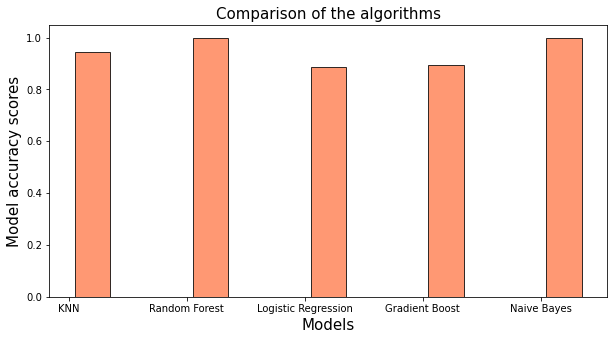

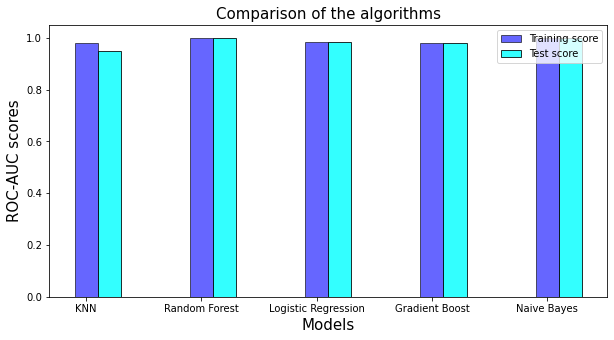

In [162]:
#plotting the accuracy scores:


index=[1,2,3,4,5,6]
index_acc=[1.2,2.2,3.2,4.2,5.2]
plt.figure(figsize=(10,5))
plt.xlabel('Models',fontsize=15)
plt.ylabel ('Model accuracy scores',fontsize=15)
plt.title('Comparison of the algorithms',fontsize=15)
#patterns = [ "/"]
_=plt.bar(index_acc,Accuracy_score,color='coral',alpha=0.8,label='Accuracy score',edgecolor='k',width=0.3)
plt.xticks([1, 2,3,4,5], labels)
#plt.legend()
plt.savefig("26.png")
plt.show()

#plotting and comparing ROC-AUC train/test scores:

index=[1,2,3,4,5]
index_acc=[1.2,2.2,3.2,4.2,5.2]
plt.figure(figsize=(10,5))
plt.xlabel('Models',fontsize=15)
plt.ylabel ('ROC-AUC scores',fontsize=15)
plt.title('Comparison of the algorithms',fontsize=15)
_=plt.bar(index,score_train,color='b',alpha=0.6,label='Training score',edgecolor='k',width=0.2)
_=plt.bar(index_acc,score_test,color='cyan',alpha=0.8,label='Test score',edgecolor='k',width=0.2)
plt.xticks([1, 2,3,4,5], labels)
plt.legend()
plt.savefig("27.png")
plt.show()

# 7. Summary and Conclusion

TIn this project we are dealing with classificion problem. Thus, to predict the severity of a crash, we have considered the following classification models:
        K-Nearest Neighbor (KNN)
        Random Forest
        Logistic Regression
        Gradient Boost
        Naive Bayes
        

To avoid overfitting, it is not recommended to evaluate the performance of a model by training and testing on the same dataset. Instead, the dataset should be split into a train set and a validation set for model evaluation. However, the choice of (train, validation) set can affect the performance of the model, which can be overcome by using the Cross-Validation (CV) procedure. Under the k-fold CV approach, the training set is split into k smaller sets, where a model is trained using k-1 of the folds as training data and validated on the remaining part.

In our study, we evaluated the performance of each model in terms of model accuracy score and ROC-AUC score for both the training and test data. We also plotted the results to visually inspect the outcome. Based on our analysis, the Random Forest and Naive Bayes were the best performing models.

We also used Grid Search CV to find the optimal hyperparameters for the KNN algorithm. The result, Best Parameters: for n_neighbors: 9, was determined and used to train and evaluate the KNN classifier on the test set. The accuracy score on the test set was 0.92.

Note: the Computational time is an important consideration when using Grid Search CV for hyperparameter tuning. 


# 8. Future project/direction

In this case study, to deal with the imbalanced data, we used the imblearn.under_sampling library and implemented its techniques for under-sampling the majority class. 

This helped to address the problem of imbalanced datasets by reducing the number of samples in the majority class, which at the same time helped to improve the performance of our models.

On the other hand, Under-sampling the majority class can lead to loss of information and may result in biased models. This is because random under-sampling can result in loss of important information that may be present in the majority class.

Because of the reasons mentioned above, the next step would be to over-sample the minority class to address the problem of imbalanced datasets.This technique involves generating new synthetic samples for the minority class, which can be used to balance the dataset.

Ultimately, Implementing both techniques will give us a better understanding of which model performance best.